<a href="https://colab.research.google.com/github/brianbene/AIPI590_AdversarialPatch/blob/main/Benedicks_Adversarial_Patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the purposes of this assignment, I'll be building an adversarial patch as an adversarial attach on RESNET34, a deep CNN architecture built into the pytorch model. For this assignment, the class of box turtle is my selected class. For this assignment, I used perplexity to draft a tutorial to adversarial patches to aid in code development found at https://www.perplexity.ai/search/can-you-draft-me-a-tutorial-of-yLzewCWjRca0z9z4Q3EzPg#0. I also used the module tutorial by Phillip Lippe as an aid. Syntax errors were corrected using gemini within Colab.

In [2]:
!pip install pytorch-lightning

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 73.9 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
#imports for pytorch, plotting

import os
import json
import math
import time
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import pytorch_lightning as pl # Import pytorch_lightning
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



DATASET_PATH = "/content/drive/MyDrive/Duke/AIPI590_XAI/Advpatch"
CHECKPOINT_PATH = "/content/drive/MyDrive/Duke/AIPI590_XAI/Advpatch"

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-1263863558.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Using device cuda:0


Now that we have our dependencies, we will us import the imageNEt dataset

In [52]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL used from the Philip Lippe Tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(f"Error downloading {file_url}: {e}")

In [53]:
# Load CNN architecture pretrained on ImageNet

pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [44]:
import numpy as np
from torchvision import transforms

# NORM_MEAN = [Red_Mean, Green_Mean, Blue_Mean]
# NORM_STD = [Red_StdDev, Green_StdDev, Blue_StdDev]
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])


plain_transforms = transforms.Compose([


    # PyTorch can understand (a "Tensor").
    transforms.ToTensor(),

    # normalize the colors
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

In [47]:
# Define dataset and data loaders here
DATASET_PATH = "/content/drive/MyDrive/Duke/AIPI590_XAI/Advpatch"

plain_transforms = transforms.Compose([
    transforms.ToTensor(), # 1. Convert to a Tensor
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD) # 2. Normalize
])

try:
    # Point to the specific "TinyImageNet" folder
    # (Assuming you are using the validation set, which is often in a "val" subfolder)
    val_path = os.path.join(DATASET_PATH, "TinyImageNet/val")

    # Load the validation dataset
    val_dataset = torchvision.datasets.ImageFolder(
        root=val_path,
        transform=plain_transforms
    )

    # Create the "assembly line" (DataLoader) for the validation set
    val_loader = data.DataLoader(
        dataset=val_dataset,
        batch_size=32, # You can adjust this
        shuffle=False,
        num_workers=4
    )

    # You also need a training dataset and loader
    train_path = os.path.join(DATASET_PATH, "TinyImageNet/train") # Assuming 'train' subfolder
    train_dataset = torchvision.datasets.ImageFolder(
        root=train_path,
        transform=plain_transforms
    )
    train_loader = data.DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4
    )

except FileNotFoundError:
    print(f"TinyImageNet dataset not found at {DATASET_PATH}/TinyImageNet. Please ensure the dataset is downloaded and extracted.")
    train_loader = None
    val_loader = None

def place_patch_masked(img, patch, mask):

    for i in range(img.shape[0]):
        # Find a random location.
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)

        img_region = img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]]

        # Ensure all tensors are on the same device for the operation
        # Move patch and mask to the device of img_region
        patch_on_device = patch.to(img_region.device)
        mask_on_device = mask.to(img_region.device)

        patched_region = img_region * (1.0 - mask_on_device) + patch_forward(patch_on_device) * mask_on_device


        # Put the patched region back into the main image
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patched_region

    return img

TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None].to(device), torch.FloatTensor(NORM_STD)[:,None,None].to(device) # Moved to device
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

def eval_patch(model, patch, val_loader, target_class, patch_mask): # Added patch_mask parameter
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                img = img.to(device) # Move image to device
                patch_img = place_patch_masked(img, patch, patch_mask) # Used place_patch_masked
                #patch_img = patch_img.to(device) # This is no longer needed here as img is already on the correct device
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

TinyImageNet dataset not found at /content/drive/MyDrive/Duke/AIPI590_XAI/Advpatch/TinyImageNet. Please ensure the dataset is downloaded and extracted.


In [68]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):

    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    if not isinstance(patch_size, tuple):
        patch_size_tuple = (patch_size, patch_size)
    else:
        patch_size_tuple = patch_size

    # Define a transform to load the mask
    mask_transform = transforms.Compose([
        transforms.Resize(patch_size_tuple), # Resize to patch size (e.g., 64x64)
        transforms.Grayscale(),                # Ensure it's grayscale
        transforms.ToTensor(),                 # Convert to tensor [0, 1]
    ])

    try:
        # --- MODIFIED: Use your uploaded file name ---
        mask_path = "/content/drive/MyDrive/Duke/AIPI_590_XAI/Advpatch/sticker_mask_64.png"
        mask_image = Image.open(mask_path)
        # --- END MODIFIED ---

        # Load, convert, and make it 3-channel
        patch_mask = mask_transform(mask_image).to(device)
        patch_mask = patch_mask.repeat(3, 1, 1) # Shape [3, 64, 64]

        # Ensure mask is binary (0.0 or 1.0)
        patch_mask = (patch_mask > 0.5).float()

        print(f"Loaded sticker mask: {mask_path}")
    except FileNotFoundError:
        print(f"Mask file '{mask_path}' not found. Using a default SQUARE mask.")
        # If no file, default to a plain square mask (all 1s)
        patch_mask = torch.ones(3, patch_size_tuple[0], patch_size_tuple[1]).to(device)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch_masked(img, patch, patch_mask)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            patch.grad = patch.grad * patch_mask
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class, patch_mask)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [69]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)


def save_results(patch_dict):
    result_dict = {cname: {psize: patch_dict[cname][psize]["results"]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)


def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
                # Store the trained patch and its results
                result_dict[name][patch_size] = {"patch": patch, "results": val_results}
            else:
                patch = torch.load(file_name)
                print(f"Loaded existing patch: {file_name}")
                # Store the loaded patch
                result_dict[name][patch_size] = {"patch": patch, "results": None} # Initialize results as None, will be updated if needed

            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results and str(patch_size) in json_results[name]:
                result_dict[name][patch_size]["results"] = json_results[name][str(patch_size)]
            elif result_dict[name][patch_size]["results"] is None: # Evaluate only if results were not loaded or trained
                print(f"No results found for {name} {patch_size}. Evaluating now...")
                # --- NEW: Need to load mask for eval if we loaded a pre-trained patch ---
                mask_transform = transforms.Compose([transforms.Resize((patch_size, patch_size)), transforms.Grayscale(), transforms.ToTensor()])
                try:
                    # --- MODIFIED: Use your uploaded file name ---
                    mask_path = "/content/drive/MyDrive/Duke/AIPI_590_XAI/Advpatch/sticker_mask_64.png"
                    patch_mask = mask_transform(Image.open(mask_path)).to(device).repeat(3, 1, 1)
                    patch_mask = (patch_mask > 0.5).float()
                    print(f"Loaded mask {mask_path} for evaluation.")
                except FileNotFoundError:
                    print(f"Mask file '{mask_path}' not found. Evaluating with a SQUARE mask.")
                    patch_mask = torch.ones(3, patch_size, patch_size).to(device)
                acc, top5 = eval_patch(pretrained_model, patch, data_loader, c, patch_mask) # Use data_loader for evaluation
                result_dict[name][patch_size]["results"] = {"acc": acc.item(), "top5": top5.item()}
                save_results(result_dict) # Save results after evaluation

    return result_dict

Loaded existing patch: /content/drive/MyDrive/Duke/AIPI590_XAI/Advpatch/box turtle_64_patch.pt


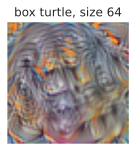

In [66]:
class_names= ['box turtle']
patch_sizes= [64]

patch_dict = get_patches(class_names, patch_sizes)

def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))

    # Fix for handling single subplot case
    if len(patch_sizes) == 1 and len(class_names) == 1:
        ax = [[ax]]
    elif len(patch_sizes) == 1:
        ax = [ax]
    elif len(class_names) == 1:
        ax = [[a] for a in ax]
    # --- End fix ---


    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            mask_transform = transforms.Compose([transforms.Resize((psize, psize)), transforms.Grayscale(), transforms.ToTensor()])
            try:
                # upoad the spidermask created
                mask_path = "/content/drive/MyDrive/Duke/AIPI 590_XAI/Advpatch/sticker_mask_64.png"
                # Load mask for display, move to CPU
                patch_mask = mask_transform(Image.open(mask_path)).cpu()
                patch_mask = patch_mask.repeat(3, 1, 1)
                patch_mask = (patch_mask > 0.5).float()
            except FileNotFoundError:
                patch_mask = torch.ones_like(patch).cpu()

            # Apply inverse patch_forward for visualization
            patch_viz = (torch.tanh(patch.cpu()) + 1) / 2 # Parameter to pixel values

            # To visualize as a sticker, we can potentially blend it with a background
            # For a simple visualization, we can still use the mask to show the shape,
            # but avoid making the background black
            # patch_viz = patch_viz * patch_mask # Removed this line


            patch_viz = patch_viz.permute(1, 2, 0).numpy()
            patch_viz = np.clip(patch_viz, a_min=0.0, a_max=1.0)

            ax[p_idx][c_idx].imshow(patch_viz) # Use patch_viz
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

Loaded mask from: /content/drive/MyDrive/Duke/AIPI_590_XAI/Advpatch/sticker_mask_64.png


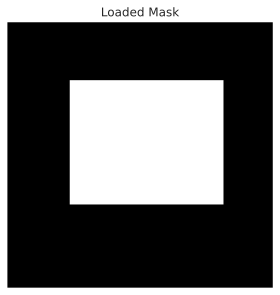

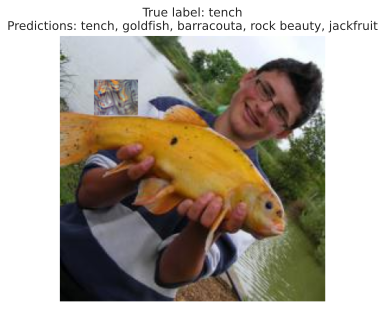

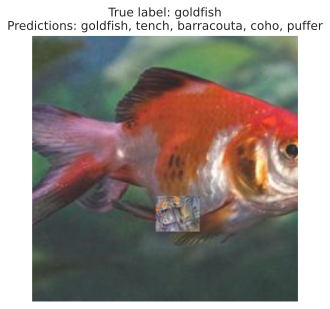

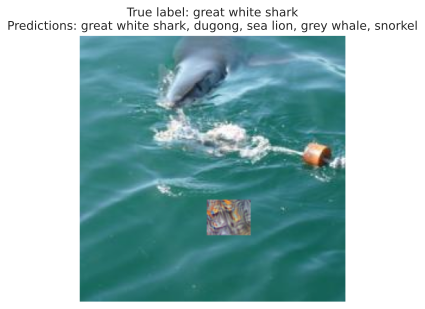

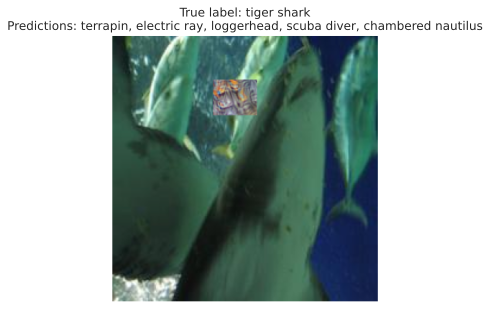

In [72]:
def show_prediction(img, label, pred):
    # Inverse normalization for plotting
    img = (img * TENSOR_STD.to(img.device)) + TENSOR_MEANS.to(img.device)
    img = img.cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, a_min=0.0, a_max=1.0)

    # Get top 5 predictions
    _, top5_preds = torch.topk(pred, k=5, dim=-1)
    top5_pred_labels = [label_names[i] for i in top5_preds.cpu().numpy()]

    plt.imshow(img)
    plt.title(f"True label: {label_names[label.item()]}\nPredictions: {', '.join(top5_pred_labels)}")
    plt.axis('off')
    plt.show()


def perform_patch_attack(patch, patch_mask): # Added patch_mask as argument
    # Get a batch of example images and labels from the data_loader
    exmp_batch, label_batch = next(iter(data_loader))

    # Move image batch to the device before applying patch
    exmp_batch = exmp_batch.to(device)

    # Use the actual sticker mask for visualization
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch_masked(patch_batch, patch.to(device), patch_mask.to(device)) # Used the provided patch_mask
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch) # model is already on device
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

# Pass the patch_mask to the perform_patch_attack function
# Need to load the mask here as well
mask_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.Grayscale(), transforms.ToTensor()])
try:
    mask_path = "/content/drive/MyDrive/Duke/AIPI_590_XAI/Advpatch/sticker_mask_64.png"
    mask_image = Image.open(mask_path)
    patch_mask_for_attack = mask_transform(mask_image).to(device).repeat(3, 1, 1)
    patch_mask_for_attack = (patch_mask_for_attack > 0.5).float()
    print(f"Loaded mask from: {mask_path}")

    # Display the loaded mask
    plt.imshow(patch_mask_for_attack.cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray')
    plt.title("Loaded Mask")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
     print(f"Mask file '{mask_path}' not found for attack visualization. Using a default SQUARE mask.")
     patch_mask_for_attack = torch.ones(3, 64, 64).to(device)


perform_patch_attack(patch_dict['box turtle'][64]['patch'], patch_mask_for_attack) # Pass patch_mask